# Homework6

In [14]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt

from collections import defaultdict
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
from torchvision.utils import make_grid
# from fastai.basics import gzip
import gzip

if torch.cuda.is_available():
    DEVICE = 'cuda'
    GPU_DEVICE = 0
    torch.cuda.set_device(GPU_DEVICE)
else:
    DEVICE='cpu'

USE_CUDA=True
print('cuda is available:', USE_CUDA)

import warnings
warnings.filterwarnings('ignore')

# dgm_utils
import sys
sys.path.append('../../homeworks') # to grab dgm_utils from ../../homeworks directory
from dgm_utils import train_model, plot_training_curves
from dgm_utils import visualize_2d_data, visualize_2d_samples
from dgm_utils import show_samples, visualize_images, load_pickle

cuda is available: True


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [19]:
def load_pickle_mnist(path, flatten=True):
    with gzip.open(path, 'rb') as f:
        data = pickle.load(f, encoding='latin-1')
    train_data = data[0][0].reshape(-1, 28, 28, 1).astype('float32') * 255 > 128
    test_data =  data[1][0].reshape(-1, 28, 28, 1).astype('float32') * 255 > 128
    train_data = np.transpose(train_data.astype('uint8'), (0, 3, 1, 2))
    test_data = np.transpose(test_data.astype('uint8'), (0, 3, 1, 2))
    if flatten:
        train_data = train_data.reshape(-1, 28 * 28)
        test_data = test_data.reshape(-1, 28 * 28)
    return train_data, test_data

def load_pickle(path):
    with open(path, 'rb') as f:
        data = pickle.load(f)
    train_data, test_data = data['train'], data['test']
    # train_data = (train_data + 1) / 2
    # test_data = (test_data + 1) / 2
    return train_data, test_data


def show_samples(samples, title, mnist=True, nrow=10, figsize=(7, 7)):
    if mnist:
        samples = torch.FloatTensor(samples).reshape(-1, 28, 28)
        samples = torch.unsqueeze(samples, axis=1)
    else:
        samples = (torch.FloatTensor(samples) / 255).permute(0, 3, 1, 2)
    grid_img = make_grid(samples, nrow=nrow)
    plt.figure(figsize = figsize)
    plt.title(title)
    plt.imshow(grid_img.permute(1, 2, 0))
    plt.axis('off')
    plt.show()


def visualize_data(data, title, mnist=True):
    idxs = np.random.choice(len(data), replace=False, size=(100,))
    images = train_data[idxs]
    show_samples(images, title, mnist=mnist)

Here are the functions that we will you for training our model. Please, explore these functions carefully. You do not have to change them.

In [4]:
def train_epoch(model, train_loader, optimizer, use_cuda, loss_key='total'):
    model.train()
  
    stats = defaultdict(list)
    for x in train_loader:
        if use_cuda:
            x = x.cuda()
        losses = model.loss(x)
        optimizer.zero_grad()
        losses[loss_key].backward()
        optimizer.step()

        for k, v in losses.items():
            stats[k].append(v.item())
    return stats


def eval_model(model, data_loader, use_cuda):
    model.eval()
    stats = defaultdict(float)
    with torch.no_grad():
        for x in data_loader:
            if use_cuda:
                x = x.cuda()
            losses = model.loss(x)
            for k, v in losses.items():
                stats[k] += v.item() * x.shape[0]

        for k in stats.keys():
            stats[k] /= len(data_loader.dataset)
    return stats


def train_model(model, train_loader, test_loader, epochs, lr, use_tqdm=False, use_cuda=False, loss_key='total_loss'):
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_losses = defaultdict(list)
    test_losses = defaultdict(list)
    forrange = tqdm(range(epochs)) if use_tqdm else range(epochs)
    if use_cuda:
        model = model.cuda()
    for epoch in forrange:
        model.train()
        train_loss = train_epoch(model, train_loader, optimizer, use_cuda, loss_key)
        test_loss = eval_model(model, test_loader, use_cuda)

        for k in train_loss.keys():
            train_losses[k].extend(train_loss[k])
            test_losses[k].append(test_loss[k])
    return dict(train_losses), dict(test_losses)


def plot_training_curves(train_losses, test_losses):
    n_train = len(train_losses[list(train_losses.keys())[0]])
    n_test = len(test_losses[list(train_losses.keys())[0]])
    x_train = np.linspace(0, n_test - 1, n_train)
    x_test = np.arange(n_test)

    plt.figure()
    for key, value in train_losses.items():
        plt.plot(x_train, value, label=key + '_train')

    for key, value in test_losses.items():
        plt.plot(x_test, value, label=key + '_test')

    plt.legend(fontsize=12)
    plt.xlabel('Epoch', fontsize=14)
    plt.ylabel('Loss', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.show()

## Task 1: PixelCNN on MNIST and CIFAR10

[PixelCNN](https://arxiv.org/abs/1601.06759) model uses masked causal convoultions on images, we have discussed this model on lecture 2.

Here you have to train this model on MNIST images.

(see paper for details: https://arxiv.org/abs/1601.06759)

### Task 1.1: Train on MNIST

In [5]:
!wget https://raw.githubusercontent.com/mnielsen/neural-networks-and-deep-learning/master/data/mnist.pkl.gz

--2022-10-23 15:46:29--  https://raw.githubusercontent.com/mnielsen/neural-networks-and-deep-learning/master/data/mnist.pkl.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17051982 (16M) [application/octet-stream]
Saving to: ‘mnist.pkl.gz’

mnist.pkl.gz        100%[===================>]  16.26M  26.1MB/s    in 0.6s    

2022-10-23 15:46:30 (26.1 MB/s) - ‘mnist.pkl.gz’ saved [17051982/17051982]



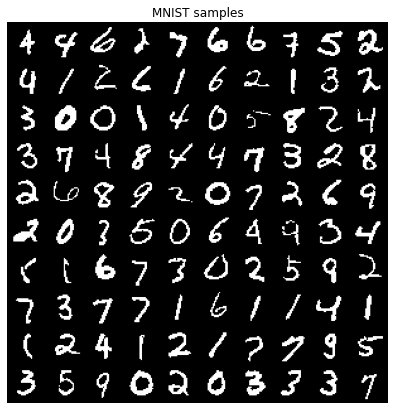

In [6]:
# change the path to the file
train_data, test_data = load_pickle_mnist(
    os.path.join('mnist.pkl.gz'),
    flatten=False
)
visualize_data(train_data, 'MNIST samples', mnist=True)

In [7]:
class MaskedConv2d(nn.Conv2d):
    def __init__(self, mask_type, in_channels, out_channels, kernel_size=5):
        assert mask_type in ['A', 'B']
        super().__init__(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, padding=kernel_size // 2)
        self.register_buffer('mask', torch.zeros_like(self.weight))
        self.create_mask(mask_type)

    def forward(self, input):
        self.weight
        # ====
        # your code
        self.weight.data*=self.mask
        return super().forward(input)
        # ====

    def create_mask(self, mask_type):
        # ====
        # your code
        # do not forget about mask_type
        kernel_size = self.mask.size(2)
        self.mask.fill_(1.)

        if mask_type =='A':
            self.mask[:,:,kernel_size//2,kernel_size//2:] = 0
            self.mask[:,:,kernel_size//2 + 1:,:] = 0
        elif mask_type =='B':
            self.mask[:,:,kernel_size//2,kernel_size//2+1:] = 0
            self.mask[:,:,kernel_size//2+1:,:] = 0
        # ====


def test_masked_conv2d():
    layer = MaskedConv2d('A', 2, 2)
    assert np.allclose(layer.mask[:, :, 2, 2].numpy(), np.zeros((2, 2)))

    layer = MaskedConv2d('B', 2, 2)
    assert np.allclose(layer.mask[:, :, 2, 2].numpy(), np.ones((2, 2)))


test_masked_conv2d()

[Layer Normalization](https://arxiv.org/abs/1607.06450) helps to stabilize training process.

In [8]:
class LayerNorm(nn.LayerNorm):
    def __init__(self, n_filters):
        super().__init__(n_filters)

    def forward(self, x):
        x = x.permute(0, 2, 3, 1).contiguous()
        x = super().forward(x)
        return x.permute(0, 3, 1, 2).contiguous()

In [9]:
class PixelCNN(nn.Module):
    def __init__(
        self, 
        input_shape, 
        n_filters=64, 
        kernel_size=7, 
        in_chanels=1,
        n_categories=2,
        n_layers=5, 
        use_layer_norm=True,
    ):
      
        super().__init__()
        self.input_shape = input_shape
        self.in_chanels = in_chanels
        self.n_categories = n_categories

        # ====
        # your code
        # apply the sequence of MaskedConv2d -> LayerNorm -> ReLU
        # note that the first conv layer should be of type 'A' 
        # the last layer should be MaskedConv2d
        if use_layer_norm:
            layers = [MaskedConv2d('A', in_chanels, n_filters, kernel_size), LayerNorm(n_filters),  nn.ReLU()]
        else:
            layers = [MaskedConv2d('A', in_chanels, n_filters),  nn.ReLU()]
        for _ in range(n_layers-2):
            layers.append(MaskedConv2d('B', n_filters, n_filters, kernel_size))
            if use_layer_norm : layers.append(LayerNorm(n_filters))
            layers.append(nn.ReLU())
        layers.append(MaskedConv2d('B', n_filters, n_categories * in_chanels, kernel_size))

        self.net = nn.Sequential(*layers)
        # ====

    def forward(self, x):
        batch_size = x.shape[0]
        scale = (self.n_categories - 1) / 2
        out = (x.float() - scale) / scale
        out = self.net(out)
        return out.view(batch_size, self.n_categories, self.in_chanels, *self.input_shape)

    def loss(self, x):
        # ====
        # your code
        return dict(total_loss = F.cross_entropy(self(x), x.long()) )
        # ====

    def sample(self, n):
        # read carefully the sampling process
        samples = torch.zeros(n, self.in_chanels, *self.input_shape).cuda()
        with torch.no_grad():
            for r in range(self.input_shape[0]):
                for c in range(self.input_shape[1]):
                    logits = self(samples)[:, :, :, r, c]
                    probs = F.softmax(logits, dim=1)
                    for i in range(probs.size(2)):
                        samples[:, i, r, c] = torch.multinomial(probs[..., i], num_samples=1).squeeze(-1)
        return samples.permute(0, 2, 3, 1).cpu().numpy()

    def autocomplete_image(self, img, n, autocomplete_lower=10):
        img_init = img.clone()
        img_init[:,autocomplete_lower:,:] = -1
        samples = img_init.unsqueeze(dim=0).expand(n,-1,-1,-1).cuda()

        with torch.no_grad():
            for r in range(autocomplete_lower, self.input_shape[0]):
                for c in range(self.input_shape[1]):
                    logits = self(samples)[:, :, :, r, c]
                    probs = F.softmax(logits, dim=1)
                    for i in range(probs.size(2)):
                        samples[:, i, r, c] = torch.multinomial(probs[..., i], num_samples=1).squeeze(-1)
        return samples.permute(0, 2, 3, 1).cpu().numpy()

In [10]:
# ====
# your code
EPOCHS = 5
BATCH_SIZE = 100
LR = 0.01
N_LAYERS = 3
N_FILTERS = 64
# ====

model = PixelCNN(
    input_shape=(28, 28), 
    n_filters=N_FILTERS, 
    kernel_size=5, 
    n_layers=N_LAYERS, 
    use_layer_norm=True,
)

loss = model.loss(torch.zeros(1, 1, 28, 28))
assert isinstance(loss, dict)
assert 'total_loss' in loss

train_loader = data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = data.DataLoader(test_data, batch_size=BATCH_SIZE)
train_losses, test_losses = train_model(model, train_loader, test_loader, epochs=EPOCHS, lr=LR, use_tqdm=True, use_cuda=USE_CUDA)

assert test_losses['total_loss'][-1] < 0.11

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:51<00:00, 10.30s/it]


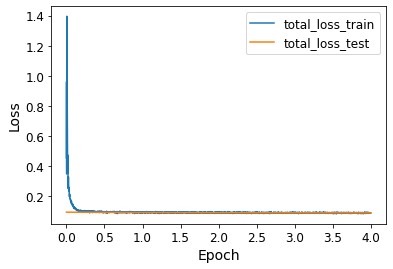

In [11]:
plot_training_curves(train_losses, test_losses)

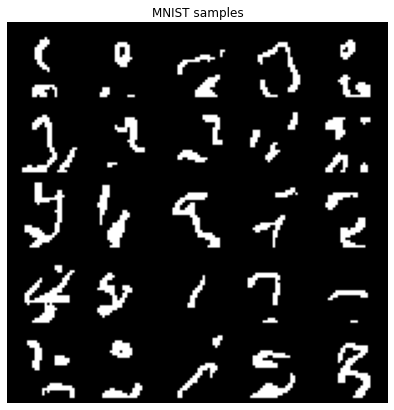

In [12]:
samples = model.sample(25)
show_samples(samples, title='MNIST samples', nrow=5)

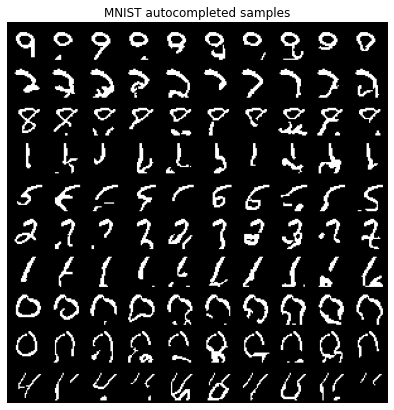

In [13]:
idxs = np.random.choice(len(train_data), replace=False, size=(10,))
imgs = torch.Tensor(train_data[idxs])
samples = []
for d in imgs:
    samples.append(np.concatenate([d.numpy()[..., None], model.autocomplete_image(d, 9, 14)]))
show_samples(np.concatenate(samples), title='MNIST autocompleted samples', nrow=10)

### Task 1.2: Train on CIFAR10

In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

f = drive.CreateFile({'id':'16j3nrJV821VOkkuRz7aYam8TyIXLnNme'})
f.GetContentFile('cifar10.pkl')

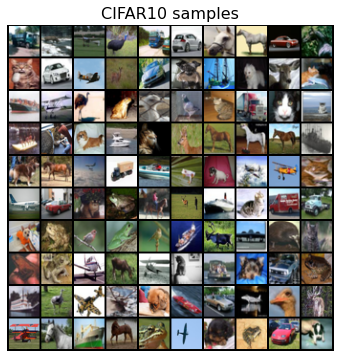

In [15]:
train_data, test_data = load_pickle('./cifar10.pkl', flatten=False, binarize=False)
visualize_images(train_data, 'CIFAR10 samples')

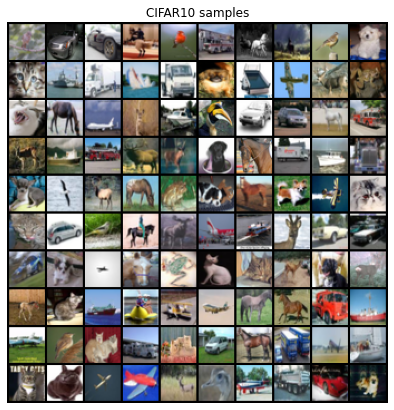

In [ ]:
# change the path to the generated data
train_data, test_data = load_pickle(os.path.join('/content', 'cifar10.pkl'))
visualize_data(train_data, 'CIFAR10 samples', mnist=False)

train_data = np.transpose(train_data, (0, 3, 1, 2)).astype('float32')
test_data = np.transpose(test_data, (0, 3, 1, 2)).astype('float32')

In [16]:
# ====
# your code
EPOCHS = 5
BATCH_SIZE = 100
LR = 0.001
N_LAYERS = 5
N_FILTERS = 128
# ====

model = PixelCNN(
    input_shape=(32, 32), 
    n_filters=N_FILTERS, 
    kernel_size=5, 
    in_chanels=3,
    n_categories=256,
    n_layers=N_LAYERS, 
    use_layer_norm=True, 
)

loss = model.loss(torch.zeros(1, 3, 32, 32))
assert isinstance(loss, dict)
assert 'total_loss' in loss

train_loader = data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = data.DataLoader(test_data, batch_size=BATCH_SIZE)
train_losses, test_losses = train_model(model, train_loader, test_loader, epochs=EPOCHS, lr=LR, use_tqdm=True, use_cuda=USE_CUDA)

# assert test_losses['total_loss'][-1] < 0.11

  0%|          | 0/5 [00:00<?, ?it/s]

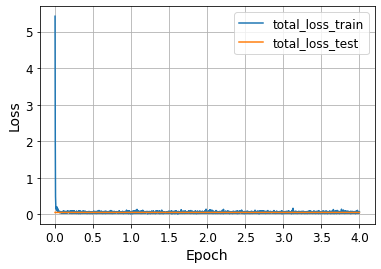

In [17]:
plot_training_curves(train_losses, test_losses)

In [18]:
samples = model.sample(25)
show_samples(samples, title='CIFAR10 samples', mnist=False, nrow=5)

TypeError: show_samples() got an unexpected keyword argument 'mnist'

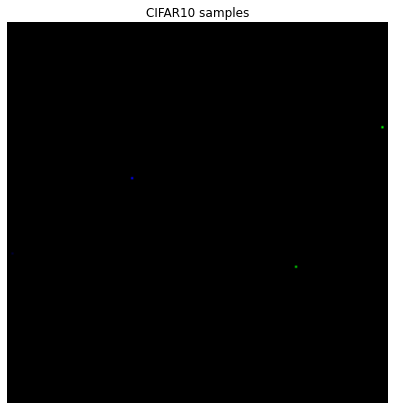

In [20]:
show_samples(samples, title='CIFAR10 samples', mnist=False, nrow=5)

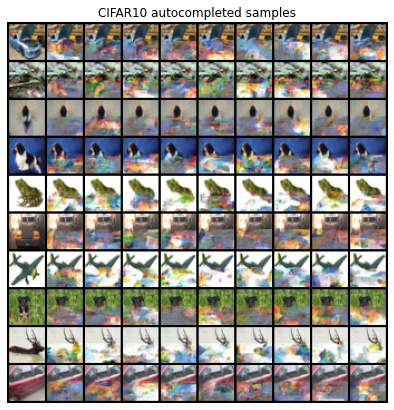

In [ ]:
idxs = np.random.choice(len(train_data), replace=False, size=(10,))
imgs = torch.Tensor(train_data[idxs])
samples = []
for d in imgs:
    samples.append(np.concatenate([d.permute(1, 2, 0).numpy()[None], model.autocomplete_image(d, 9, 14)]))
show_samples(np.concatenate(samples), title='CIFAR10 autocompleted samples', mnist=False, nrow=10)

## Task 3: PixelCNN++

[PixelCNN++](https://arxiv.org/pdf/1701.05517.pdf)

In [21]:
def discretized_mix_logistic_loss(x, l):
    """ log-likelihood for mixture of discretized logistics, assumes the data has been rescaled to [-1,1] interval """
    # Pytorch ordering
    x = x.permute(0, 2, 3, 1)
    l = l.permute(0, 2, 3, 1)
    xs = [int(y) for y in x.size()]
    ls = [int(y) for y in l.size()]
   
    # here and below: unpacking the params of the mixture of logistics
    nr_mix = int(ls[-1] / 10)
    logit_probs = l[:, :, :, :nr_mix]
    l = l[:, :, :, nr_mix:].contiguous().view(xs + [nr_mix * 3]) # 3 for mean, scale, coef
    means = l[:, :, :, :, :nr_mix]
    # log_scales = torch.max(l[:, :, :, :, nr_mix:2 * nr_mix], -7.)
    log_scales = torch.clamp(l[:, :, :, :, nr_mix:2 * nr_mix], min=-7.)
   
    coeffs = F.tanh(l[:, :, :, :, 2 * nr_mix:3 * nr_mix])
    # here and below: getting the means and adjusting them based on preceding
    # sub-pixels
    x = x.contiguous()
    x = x.unsqueeze(-1) + Variable(torch.zeros(xs + [nr_mix]).cuda(), requires_grad=False)
    m2 = (means[:, :, :, 1, :] + coeffs[:, :, :, 0, :]
                * x[:, :, :, 0, :]).view(xs[0], xs[1], xs[2], 1, nr_mix)

    m3 = (means[:, :, :, 2, :] + coeffs[:, :, :, 1, :] * x[:, :, :, 0, :] +
                coeffs[:, :, :, 2, :] * x[:, :, :, 1, :]).view(xs[0], xs[1], xs[2], 1, nr_mix)

    means = torch.cat((means[:, :, :, 0, :].unsqueeze(3), m2, m3), dim=3)
    centered_x = x - means
    inv_stdv = torch.exp(-log_scales)
    plus_in = inv_stdv * (centered_x + 1. / 255.)
    cdf_plus = F.sigmoid(plus_in)
    min_in = inv_stdv * (centered_x - 1. / 255.)
    cdf_min = F.sigmoid(min_in)
    # log probability for edge case of 0 (before scaling)
    log_cdf_plus = plus_in - F.softplus(plus_in)
    # log probability for edge case of 255 (before scaling)
    log_one_minus_cdf_min = -F.softplus(min_in)
    cdf_delta = cdf_plus - cdf_min  # probability for all other cases
    mid_in = inv_stdv * centered_x
    # log probability in the center of the bin, to be used in extreme cases
    # (not actually used in our code)
    log_pdf_mid = mid_in - log_scales - 2. * F.softplus(mid_in)

    # now select the right output: left edge case, right edge case, normal
    # case, extremely low prob case (doesn't actually happen for us)

    # this is what we are really doing, but using the robust version below for extreme cases in other applications and to avoid NaN issue with tf.select()
    # log_probs = tf.select(x < -0.999, log_cdf_plus, tf.select(x > 0.999, log_one_minus_cdf_min, tf.log(cdf_delta)))

    # robust version, that still works if probabilities are below 1e-5 (which never happens in our code)
    # tensorflow backpropagates through tf.select() by multiplying with zero instead of selecting: this requires use to use some ugly tricks to avoid potential NaNs
    # the 1e-12 in tf.maximum(cdf_delta, 1e-12) is never actually used as output, it's purely there to get around the tf.select() gradient issue
    # if the probability on a sub-pixel is below 1e-5, we use an approximation
    # based on the assumption that the log-density is constant in the bin of
    # the observed sub-pixel value
    
    inner_inner_cond = (cdf_delta > 1e-5).float()
    inner_inner_out  = inner_inner_cond * torch.log(torch.clamp(cdf_delta, min=1e-12)) + (1. - inner_inner_cond) * (log_pdf_mid - np.log(127.5))
    inner_cond       = (x > 0.999).float()
    inner_out        = inner_cond * log_one_minus_cdf_min + (1. - inner_cond) * inner_inner_out
    cond             = (x < -0.999).float()
    log_probs        = cond * log_cdf_plus + (1. - cond) * inner_out
    log_probs        = torch.sum(log_probs, dim=3) + log_prob_from_logits(logit_probs)
    
    return -torch.sum(log_sum_exp(log_probs))

In [22]:
class PixelCNNpp(nn.Module):
    def __init__(
        self, 
        input_shape, 
        n_filters=64, 
        kernel_size=7, 
        in_chanels=1,
        n_layers=5, 
        use_layer_norm=True,
    ):
      
        super().__init__()
        self.input_shape = input_shape
        self.in_chanels = in_chanels

        # ====
        # your code
        # apply the sequence of MaskedConv2d -> LayerNorm -> ReLU
        # note that the first conv layer should be of type 'A' 
        # the last layer should be MaskedConv2d
        if use_layer_norm:
            layers = [MaskedConv2d('A', in_chanels, n_filters, kernel_size), LayerNorm(n_filters),  nn.ReLU()]
        else:
            layers = [MaskedConv2d('A', in_chanels, n_filters),  nn.ReLU()]
        for _ in range(n_layers-2):
            layers.append(MaskedConv2d('B', n_filters, n_filters, kernel_size))
            if use_layer_norm : layers.append(LayerNorm(n_filters))
            layers.append(nn.ReLU())
        layers.append(MaskedConv2d('B', n_filters, in_chanels, kernel_size))

        self.net = nn.Sequential(*layers)
        # ====

    def forward(self, x):
        batch_size = x.shape[0]
        out = self.net(x)
        return out.view(batch_size, self.in_chanels, *self.input_shape)

    def loss(self, x):
        # ====
        # your code
        return dict(total_loss = discretized_mix_logistic_loss(x, self(x)))
        # ====

    # def sample(self, n):
    #     # read carefully the sampling process
    #     samples = torch.zeros(n, self.in_chanels, *self.input_shape).cuda()
    #     with torch.no_grad():
    #         for r in range(self.input_shape[0]):
    #             for c in range(self.input_shape[1]):
    #                 logits = self(samples)[:, :, :, r, c]
    #                 probs = F.softmax(logits, dim=1)
    #                 for i in range(probs.size(2)):
    #                     samples[:, i, r, c] = torch.multinomial(probs[..., i], num_samples=1).squeeze(-1)
    #     return samples.permute(0, 2, 3, 1).cpu().numpy()

    # def autocomplete_image(self, img, n, autocomplete_lower=10):
    #     img_init = img.clone()
    #     img_init[:,autocomplete_lower:,:] = -1
    #     samples = img_init.unsqueeze(dim=0).expand(n,-1,-1,-1).cuda()

    #     with torch.no_grad():
    #         for r in range(autocomplete_lower, self.input_shape[0]):
    #             for c in range(self.input_shape[1]):
    #                 logits = self(samples)[:, :, :, r, c]
    #                 probs = F.softmax(logits, dim=1)
    #                 for i in range(probs.size(2)):
    #                     samples[:, i, r, c] = torch.multinomial(probs[..., i], num_samples=1).squeeze(-1)
    #     return samples.permute(0, 2, 3, 1).cpu().numpy()

In [23]:
# ====
# your code
EPOCHS = 5
BATCH_SIZE = 100
LR = 0.001
N_LAYERS = 5
N_FILTERS = 128
# ====

model = PixelCNNpp(
    input_shape=(32, 32), 
    n_filters=N_FILTERS, 
    kernel_size=5, 
    in_chanels=3,
    n_layers=N_LAYERS, 
    use_layer_norm=True,
)

loss = model.loss(torch.zeros(1, 3, 32, 32))
assert isinstance(loss, dict)
assert 'total_loss' in loss

train_loader = data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = data.DataLoader(test_data, batch_size=BATCH_SIZE)
train_losses, test_losses = train_model(model, train_loader, test_loader, epochs=EPOCHS, lr=LR, use_tqdm=True, use_cuda=USE_CUDA)

# assert test_losses['total_loss'][-1] < 0.11

RuntimeError: shape '[1, 32, 32, 3, 0]' is invalid for input of size 3072

In [162]:
l = torch.zeros(1, 3, 32, 32)
x = model(l)

In [163]:
x = x.permute(0, 2, 3, 1)
l = l.permute(0, 2, 3, 1)
xs = [int(y) for y in x.size()]
ls = [int(y) for y in l.size()]

# here and below: unpacking the params of the mixture of logistics
nr_mix = int(ls[-1] / 10)
logit_probs = l[:, :, :, :nr_mix]
l = l[:, :, :, nr_mix:].contiguous().view(xs + [nr_mix * 3]) # 3 for mean, scale, coef
means = l[:, :, :, :, :nr_mix]

RuntimeError: ignored

In [ ]:
a = model(torch.zeros(1, 3, 32, 32))

In [ ]:
a.shape

torch.Size([1, 2, 3, 32, 32])